# Generate Dataset from all the simulation data

Output format: csv

## Sample:
```
WN1,WP1,VTH
1.0,1.0,0.6667504808394307
1.0,1.5,0.6749539226398081
1.0,2.0,0.6769565523806391
1.0,2.5,0.6858329434225444
```

VTH - Flipping voltage of the modelled LIQAF

In [12]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
from __future__ import division 
df = pd.read_csv('sim_data.csv')
print(df)
print(df.keys())
simulation_points = 184
batches = int((df.shape[0]+1)/simulation_points)
print('Batches = ', batches)

                     yes       actual_WN1      actual_WP1 
0         1.00000000e+00   1.00000000e+00  1.50000000e+00 
1                v-sweep          v(Vout)              NaN
2         0.00000000e+00  1.79999995e+00               NaN
3         1.00000000e-02  1.79999995e+00               NaN
4         2.00000000e-02  1.79999995e+00               NaN
...                  ...              ...              ...
7286578   1.76000000e+00  3.90898112e-10               NaN
7286579   1.77000000e+00  4.03624478e-10               NaN
7286580   1.78000000e+00  4.16958095e-10               NaN
7286581   1.79000000e+00  4.30916333e-10               NaN
7286582   1.80000000e+00  4.45517362e-10               NaN

[7286583 rows x 3 columns]
Index([' yes', 'actual_WN1', 'actual_WP1 '], dtype='object')
Batches =  39601


In [13]:
def interpolated_intercept(x, y1, y2):
    """Find the intercept of two curves, given by the same x data"""

    def intercept(point1, point2, point3, point4):
        """find the intersection between two lines
        the first line is defined by the line between point1 and point2
        the first line is defined by the line between point3 and point4
        each point is an (x,y) tuple.

        So, for example, you can find the intersection between
        intercept((0,0), (1,1), (0,1), (1,0)) = (0.5, 0.5)

        Returns: the intercept, in (x,y) format
        """    

        def line(p1, p2):
            A = (p1[1] - p2[1])
            B = (p2[0] - p1[0])
            C = (p1[0]*p2[1] - p2[0]*p1[1])
            return A, B, -C

        def intersection(L1, L2):
            D  = L1[0] * L2[1] - L1[1] * L2[0]
            Dx = L1[2] * L2[1] - L1[1] * L2[2]
            Dy = L1[0] * L2[2] - L1[2] * L2[0]

            x = Dx / D
            y = Dy / D
            return x,y

        L1 = line([point1[0],point1[1]], [point2[0],point2[1]])
        L2 = line([point3[0],point3[1]], [point4[0],point4[1]])

        R = intersection(L1, L2)

        return R

    idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)
    xc, yc = intercept((x[idx], y1[idx]),((x[idx+1], y1[idx+1])), ((x[idx], y2[idx])), ((x[idx+1], y2[idx+1])))
    return xc,yc


0.6764106470255021
(76.0, 66.0, 0.6764106470255021)


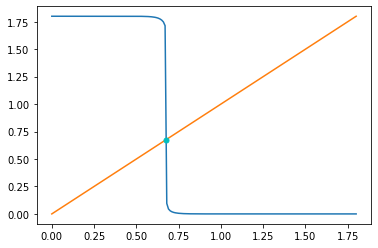

In [14]:
batch_number = 29980
batch_start = batch_number * simulation_points
sub_data = df[ batch_start : batch_start + simulation_points-1]
# print(sub_data)
WN1 = float(sub_data['actual_WN1'][batch_start])
WP1 = float(sub_data['actual_WP1 '][batch_start])
# Offset to compensate bug in spice
WP1 = WP1 - 0.5
VIN = np.fromiter(map(float, sub_data[' yes'][2:]), dtype=np.float64)
VOUT = np.fromiter(map(float, sub_data['actual_WN1'][2:]), dtype=np.float64)

xc, yc = interpolated_intercept(VIN,VIN,VOUT)
VTH = xc[0][0]

plt.plot(VIN, VOUT, VIN, VIN)
plt.plot(xc, yc, 'co', ms=5, label='Nearest data-point, with linear interpolation')

print(VTH)

data = (WN1, WP1, VTH)
print(data)

In [15]:
out = pd.DataFrame(columns = ['WN1', 'WP1', 'VTH'])
for batch_number in range(0,batches):
    batch_start = batch_number * simulation_points
    sub_data = df[ batch_start : batch_start + simulation_points-1]
    # print(sub_data)
    WN1 = float(sub_data['actual_WN1'][batch_start])
    WP1 = float(sub_data['actual_WP1 '][batch_start])
    # Offset to compensate bug in spice
    WP1 = WP1 - 0.5
    VIN = np.fromiter(map(float, sub_data[' yes'][2:]), dtype=np.float64)
    VOUT = np.fromiter(map(float, sub_data['actual_WN1'][2:]), dtype=np.float64)

    xc, yc = interpolated_intercept(VIN,VIN,VOUT)
    VTH = xc[0][0]

    out = out.append({'WN1':WN1, 'WP1':WP1, 'VTH':VTH}, ignore_index= True)
print(out)

         WN1    WP1       VTH
0        1.0    1.0  0.666750
1        1.0    1.5  0.674954
2        1.0    2.0  0.676957
3        1.0    2.5  0.685833
4        1.0    3.0  0.687465
...      ...    ...       ...
39596  100.0   98.0  0.686197
39597  100.0   98.5  0.686202
39598  100.0   99.0  0.686207
39599  100.0   99.5  0.686212
39600  100.0  100.0  0.686216

[39601 rows x 3 columns]


In [16]:
out.to_csv('Dataset.csv',index=False)